# Problem Set - Week 3
### Guillermo Trefogli

In [1]:
import math
import scipy as sp
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import kpss

import warnings
warnings.filterwarnings('ignore')

## 1.  Exploratory Data Analysis

### A. EDA

- There are 3 variables in the dataset: one measure for time (date) and 2 floats variables: gdp and unemployment rate. 
- There are no missing values
- The ACF tests for gdp and urate are showing that autocorrelation is present for them but it seems to involve leass lags for urate than for gdp
- The time series plot for gdp and urate shows that gdp and urate have different pattenrs through time: gdp has a clear trend of increasing over time but urate seems to be have a different pattern increasing and decreasing at different periods.

In [2]:
df = pd.read_csv('hw3_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    292 non-null    object 
 1   gdp     292 non-null    float64
 2   urate   292 non-null    float64
dtypes: float64(2), object(1)
memory usage: 7.0+ KB


In [4]:
df.describe()

,gdp,urate
count,292.000000,292.00000
mean,6481.725808,5.77911
std,6487.790355,1.74368
min,265.742000,2.60000
25%,802.669250,4.50000
50%,4046.925500,5.60000
75%,11011.904000,6.82500
max,21747.394000,14.80000


In [5]:
df.isnull().sum()

date     0
gdp      0
urate    0
dtype: int64

In [6]:
df.corr()

,gdp,urate
gdp,1.00000,0.14432
urate,0.14432,1.00000


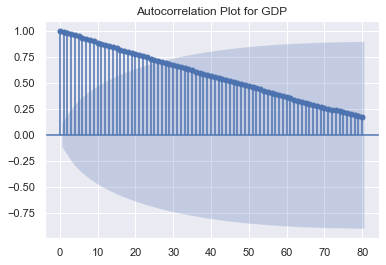

In [7]:
acf_plot_gdp= plot_acf(df['gdp'], lags=80, title='Autocorrelation Plot for GDP')

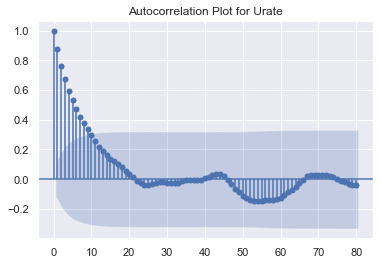

In [8]:
acf_plot_gdp= plot_acf(df['urate'], lags=80, title='Autocorrelation Plot for Urate')

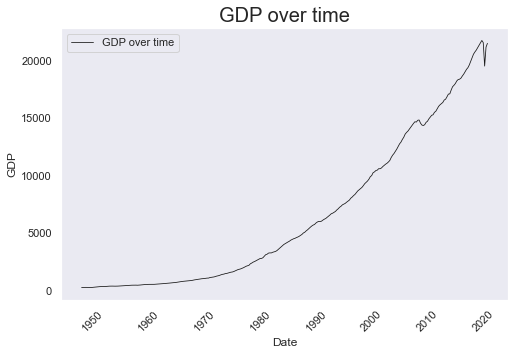

In [9]:
x = df['date']
x = pd.to_datetime(x)

y = df['gdp']

plt.figure(figsize=(8,5))  
plt.plot(x, y, color = 'k',label = "GDP over time", ls = '-', lw = 0.8)

plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('GDP')
plt.title('GDP over time', fontsize = 20)
plt.grid()
plt.legend()
plt.show()

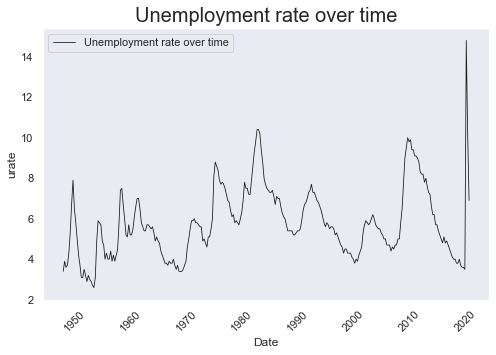

In [10]:
x = df['date']
x = pd.to_datetime(x)

y = df['urate']

plt.figure(figsize=(8,5))  
plt.plot(x, y, color = 'k',label = "Unemployment rate over time", ls = '-', lw = 0.8)

plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('urate')
plt.title('Unemployment rate over time', fontsize = 20)
plt.grid()
plt.legend()
plt.show()

### B. Okun’s Law

### C. Changes as a percentage 
(For date 4/1/1948 GDP change = 2.568, UE diff = 0.5)

In [11]:
df.set_index('date', inplace = True)

df['gdp_pct_change'] = df['gdp'].pct_change()*100
df['urate_pct_pt_change'] = df['urate'].diff()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 292 entries, 1/1/1948 to 10/1/2020
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gdp                  292 non-null    float64
 1   urate                292 non-null    float64
 2   gdp_pct_change       291 non-null    float64
 3   urate_pct_pt_change  291 non-null    float64
dtypes: float64(4)
memory usage: 11.4+ KB


In [13]:
df.dropna(subset = ['gdp_pct_change', 'urate_pct_pt_change'], how='any',inplace=True)

### D. Splitting data and creating sccatterplot

In [14]:
from sktime.forecasting.all import temporal_train_test_split
y_train, y_test = temporal_train_test_split(df)

In [15]:
y_train.index.min(), y_train.index.max()

('1/1/1949', '7/1/2002')

In [16]:
y_test.index.min(), y_test.index.max()

('1/1/2003', '7/1/2020')

In [17]:
print(y_train.shape)
print(y_test.shape)

(218, 4)
(73, 4)


gdp                   -0.031490
urate                  0.127573
gdp_pct_change        -0.528613
urate_pct_pt_change    1.000000
Name: urate_pct_pt_change, dtype: float64


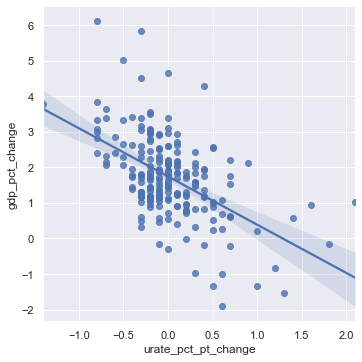

In [18]:
#df.plot.scatter(x='date', y='gdp', c='DarkBlue', title='GDP Over Time')
sns.lmplot(data = y_train, x = 'urate_pct_pt_change', y = 'gdp_pct_change')
print(y_train.corr()['urate_pct_pt_change'])

### E. Linear model on trainning set

### F. Use of model

## 2. GDP

### A. Stationarity on training set

- **ADF tests** are showing that the p-values are greater than 0.05 for **GDP**. This means that the **Null Hypothesis of non-stationarity cannot be rejected**.

- **KPSS tests** are showing that the p-values are smaller than 0.05 for **GDP**. This means that the **Null Hypothesis of **stationarity in the time series can be rejected**.

- We can see that the time series get stationary once we run the second difference. 

- See results visually and statistically below. 

#### Testing stationarity

In [19]:
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from copy import deepcopy

alpha = 0.05

def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
def kpss_test(timeseries, trend='c'):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression=trend)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)    

#### Statistically

In [20]:
adf_test(y_train['gdp'])

Results of Dickey-Fuller Test:
Test Statistic                   1.285277
p-value                          0.996525
#Lags Used                      15.000000
Number of Observations Used    202.000000
Critical Value (1%)             -3.463144
Critical Value (5%)             -2.875957
Critical Value (10%)            -2.574455
dtype: float64


In [21]:
kpss_test(y_train['gdp'])

Results of KPSS Test:
Test Statistic            1.317456
p-value                   0.010000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


#### Visually

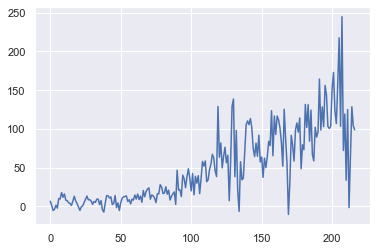

In [22]:
gdp_first_order = np.diff(y_train['gdp'])
plt.plot(gdp_first_order)

#### After second diffence

In [23]:
gdp_second_order = np.diff(gdp_first_order)

In [24]:
adf_test(gdp_second_order)

Results of Dickey-Fuller Test:
Test Statistic                -6.221139e+00
p-value                        5.219908e-08
#Lags Used                     1.400000e+01
Number of Observations Used    2.010000e+02
Critical Value (1%)           -3.463309e+00
Critical Value (5%)           -2.876029e+00
Critical Value (10%)          -2.574493e+00
dtype: float64


In [25]:
kpss_test(gdp_second_order)

Results of KPSS Test:
Test Statistic            0.050236
p-value                   0.100000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


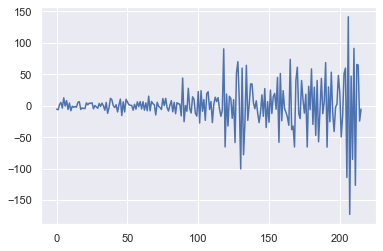

In [26]:
plt.plot(gdp_second_order)

### B. ACF and PACF plots

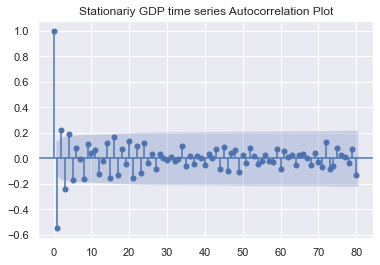

In [27]:
acf_plot = plot_acf(gdp_second_order, lags=80, title='Stationariy GDP time series Autocorrelation Plot')

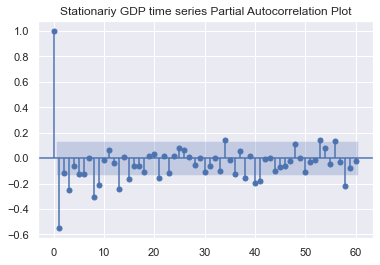

In [29]:
pacf_plot = plot_pacf(gdp_second_order, lags=60, title='Stationariy GDP time series Partial Autocorrelation Plot')

### C. ARIMA

In [61]:
from statsmodels.tsa.arima.model import ARIMA
ar_model = ARIMA(y_train['gdp'], order=(1,0,0))

In [71]:
model_fit = ar_model.fit()

In [75]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    gdp   No. Observations:                  218
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1235.746
Date:                Fri, 22 Apr 2022   AIC                           2477.493
Time:                        21:49:32   BIC                           2487.646
Sample:                    04-01-1948   HQIC                          2481.594
                         - 07-01-2002                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3223.3977      0.424   7607.836      0.000    3222.567    3224.228
ar.L1          0.9999      0.000   5313.541      0.000       1.000       1.000
sigma2      4713.9196    398.348     11.834      0.000    3933.173    5494.667
===================================================================================
Ljung-Box (L1) (Q):                 119.57   Jarque-Bera (JB):                41.63
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              98.31   Skew:                             1.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.13e+18. Standard errors may be unstable.
"""

## D. Residuals

In [77]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

In [81]:
mean_absolute_percentage_error(y_test['gdp'], model_fit)

TypeError: Expected sequence or array-like, got <class 'statsmodels.tsa.arima.model.ARIMAResultsWrapper'>

In [87]:
type(model_fit)

statsmodels.tsa.arima.model.ARIMAResultsWrapper

## 3 Unemployment rate

### A. Stationarity on training set

#### Summary:

- **ADF tests** are showing that the p-values are lower than 0.05 for **Urate**. This means that the **Null Hypothesis of non-stationarity can be rejected**.

- **KPSS tests** are showing that the p-values are greater than 0.05 for **Urate**. This means that the **Null Hypothesis of **stationarity in the time series cannot be rejected**.

- We can see that the time series get stationary once we run the difference versus one lag period. 

- See results visually and statistically below. 

#### Statistically

In [ ]:
adf_test(df['urate'])

In [ ]:
kpss_test(df['urate'])

#### Visually

In [ ]:
dif_gdp = (df['urate'] - df['urate'].shift()).iloc[1:]
dif_gdp.plot()